Analysis the results under new code

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from joblib import Parallel, delayed

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2
from IPython.display import display
import pandas as pd
from collections import defaultdict as ddict



In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT

from utils.misc import save_pkl, load_pkl, get_local_min_idxs
from utils import colors


In [5]:
import logging
from optimization.opt import logger as logger1
logger1.handlers[0].setLevel(logging.WARNING)

plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_dtype(torch.float64)

In [6]:
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]

In [24]:
is_logi = True
if is_logi:
    all_res = load_pkl(RES_ROOT/f"simu_logi_alpconv_n100/all-valsel-metrics.pkl")
else:
    all_res = load_pkl(RES_ROOT/f"simu_alpconv_n100/all-valsel-metrics.pkl")
all_coms = np.array(list(all_res.keys()))
seeds = np.sort(np.unique(all_coms[:, 0]))
can_Ns = np.sort(np.unique(all_coms[:, 1]))
can_lams = np.sort(np.unique(all_coms[:, 2]));
print(can_lams)
print(can_Ns)
ns = [100, 200, 400, 800, 1600, 3200]
num_rep = 1000

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/alp_conv/../../mypkg/../results/simu_logi_alpconv_n100/all-valsel-metrics.pkl
[0.1 0.2 0.3 0.4 0.6 0.8 1.  1.2 1.4]
[ 4.  6.  8. 10.]


1000

In [25]:
cols = colors.div_cmap(2)
norm_ci = 0.95
qv = np.abs(scipy.stats.norm.ppf((1-norm_ci)/2))

1.959963984540054

In [26]:
def get_ci(est_alp, cov_mat, alp_idx, qv=1.96):
    ci_lim = qv*cov_mat[alp_idx, alp_idx].sqrt().item()
    ci = [est_alp[alp_idx].item()-ci_lim,  est_alp[alp_idx].item()+ci_lim]
    return ci
def get_alp_cov(hdf_fit):
    Q_mat = hdf_fit.hypo_utils.Q_mat_part
    Q_mat_inv = torch.linalg.pinv(Q_mat, hermitian=True, rtol=1e-7)
    Sig_mat = hdf_fit.hypo_utils.Sig_mat_part
    Cov_mat = Q_mat_inv @ Sig_mat @  Q_mat_inv / hdf_fit.data_params.n
    return Cov_mat[:hdf_fit.data_params.q,:hdf_fit.data_params.q];

In [27]:
if True:
    def _run_fn1(seed, all_cv_errs):
        errs_mat = []
        for cur_N in can_Ns:
            errs = []
            for cur_lam in can_lams:
                errs.append(all_cv_errs[(seed, cur_N, cur_lam)].mse_loss)
            errs_mat.append(errs)
        errs_mat = np.array(errs_mat)
        return errs_mat
    opt_lamNs_fix = {}
    for n in ns:
        if is_logi:
            cur_save_dir = RES_ROOT/f"simu_logi_alpconv_n{n}"
        else:
            cur_save_dir = RES_ROOT/f"simu_alpconv_n{n}"
        all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics.pkl")
        num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
        # do not make n_jobs>1, it is very slow
        with Parallel(n_jobs=1) as parallel:
            err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                                     for cur_seed in tqdm(range(num_seed), 
                                                          total=num_seed, desc=f"n: {n}"))
        err_ten = np.array(err_ten);
        
        err_ten_ses = err_ten.std(axis=0)/np.sqrt(err_ten.shape[0])
        err_m = np.mean(np.array(err_ten), axis=0)
        errs = []
        for err in err_m:
            lam_min_idx = _get_min_idx(err)
            errs.append((err[lam_min_idx], lam_min_idx))
        errs = np.array(errs)
        N_min_idx = np.argmin(errs[:, 0]);
        lam_min_idx = int(errs[N_min_idx][1]);
        min_opt_N, min_opt_lam = can_Ns[N_min_idx], can_lams[lam_min_idx]
        
        err_upbd = err_m[N_min_idx, lam_min_idx] + err_ten_ses[N_min_idx, lam_min_idx]; 
        lam_1se_idx = np.where(err_m[N_min_idx] <= err_upbd)[0].max();
        print(n, can_Ns[N_min_idx], can_lams[lam_min_idx])
        opt_lamNs_fix[n] = (can_Ns[N_min_idx],  can_lams[lam_min_idx])
    
    
gt_alp = np.array([5, -1, 2]) 
ress_dict = {}
for n in ns:
    if is_logi:
        cur_save_dir = RES_ROOT/f"simu_logi_alpconv_n{n}"
    else:
        cur_save_dir = RES_ROOT/f"simu_alpconv_n{n}"
    cur_N, cur_lam = opt_lamNs_fix[n]
    def _run_fn_test(cur_seed):
        from optimization.opt import logger as logger1
        logger1.handlers[0].setLevel(logging.WARNING)
        torch.set_default_dtype(torch.float64)
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}_fit.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res1.sel_idx_SIS = np.where(np.array([keep_idx in 
                                              res1.sel_idx for keep_idx in res1.keep_idxs]))[0]
        res = edict()
        res.est_alp = res1.est_alp
        res.cov_mat = res1.get_covmat().alpha
        #res.cov_mat = get_alp_cov(res1)
        res.ci_lens = np.zeros(len(gt_alp)-1)
        res.cov_probs = np.zeros(len(gt_alp)-1)
        for alp_idx in range(1, res1.data_params.q):
            ci = get_ci(res.est_alp, res.cov_mat, alp_idx=alp_idx, qv=qv) 
            res.cov_probs[alp_idx-1] = np.bitwise_and(ci[0] <= gt_alp[alp_idx], 
                                                      ci[1] >= gt_alp[alp_idx]).mean()
            res.ci_lens[alp_idx-1]= np.diff(ci)
        
        res.err = np.linalg.norm(res.est_alp[1:]-gt_alp[1:])
        return res 
    with Parallel(n_jobs=10) as parallel:
        ress = parallel(delayed(_run_fn_test)(cur_seed) for cur_seed in tqdm(range(num_rep), desc=f"n: {n}", 
                                                                             total=num_rep))
    ress_dict[n] = ress

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/alp_conv/../../mypkg/../results/simu_logi_alpconv_n100/all-valsel-metrics.pkl


n: 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 17904.48it/s]

100 6.0 0.3
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/alp_conv/../../mypkg/../results/simu_logi_alpconv_n200/all-valsel-metrics.pkl



n: 200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 18353.41it/s]


200 6.0 0.2
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/alp_conv/../../mypkg/../results/simu_logi_alpconv_n400/all-valsel-metrics.pkl


n: 400: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 19268.21it/s]


400 8.0 0.2
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/alp_conv/../../mypkg/../results/simu_logi_alpconv_n800/all-valsel-metrics.pkl


n: 800: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 18307.34it/s]


800 8.0 0.2
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/alp_conv/../../mypkg/../results/simu_logi_alpconv_n1600/all-valsel-metrics.pkl


n: 1600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 18359.83it/s]


1600 8.0 0.2
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/alp_conv/../../mypkg/../results/simu_logi_alpconv_n3200/all-valsel-metrics.pkl


n: 3200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 17890.74it/s]


3200 10.0 0.2


n: 3200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.71it/s]


In [28]:
err_infos = []
ci_infos = []
cov_prob_infos = []
for n in ns:
    ress = ress_dict[n]
    errs = np.array([res.err for res in ress])
    err_cilim = qv*errs.std()/np.sqrt(len(errs))
    err_info = [errs.mean(), 
                 errs.mean()-err_cilim, 
                 errs.mean()+err_cilim]
    
    ci_lens = np.array([res.ci_lens for res in ress]);
    ci_len_cilim = 1.96*ci_lens.std(axis=0)/np.sqrt(ci_lens[0])
    ci_info = np.array(
        [ci_lens.mean(axis=0), 
         ci_lens.mean(axis=0)-ci_len_cilim, 
         ci_lens.mean(axis=0)+ci_len_cilim])
    
    cov_prob = np.array([res.cov_probs for res in ress])
    cov_prob_mean = cov_prob.mean(axis=0);
    cov_prob_cilim = 1.96 * cov_prob.std(axis=0)/np.sqrt(len(ress))
    cov_prob_info = np.array([
        cov_prob_mean, 
        cov_prob_mean-cov_prob_cilim,
        cov_prob_mean+cov_prob_cilim,
    ])
    
    err_infos.append(err_info)
    ci_infos.append(ci_info)
    cov_prob_infos.append(cov_prob_info)

err_infos = np.array(err_infos)
ci_infos = np.array(ci_infos)
cov_prob_infos = np.array(cov_prob_infos);

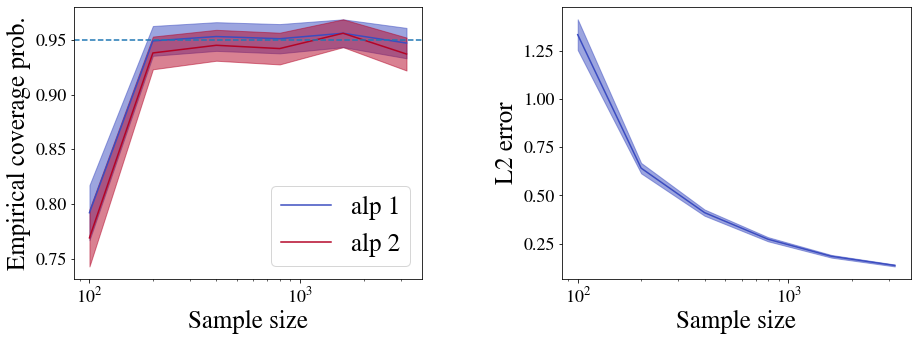

In [18]:
plt.figure(figsize=[15, 5])
plt.subplot(121)
for alp_ix in range(len(gt_alp)-1):
    plt.plot(ns, cov_prob_infos[:, 0, alp_ix], label=f"alp {alp_ix+1}", 
             color=cols[alp_ix])
    plt.fill_between(ns, cov_prob_infos[:, 1, alp_ix], cov_prob_infos[:, 2, alp_ix], 
                     color=cols[alp_ix], alpha=0.5)
plt.axhline(y=norm_ci, ls="--")
plt.xscale("log")
plt.ylabel("Empirical coverage prob.")
plt.xlabel("Sample size")
plt.legend()
#plt.subplot(132)
#for alp_ix in range(len(gt_alp)-1):
#    plt.plot(ns, ci_infos[:, 0, alp_ix], 
#             label=f"alp {alp_ix+1}", 
#            color=cols[alp_ix])
#    plt.fill_between(ns, ci_infos[:, 1, alp_ix], ci_infos[:, 2, alp_ix], 
#                     color=cols[alp_ix], alpha=0.5)
#plt.xlabel("Sample size")
#plt.ylabel("Len of CIs")
#plt.xscale("log")
#plt.legend()

plt.subplot(122)
plt.plot(ns, err_infos[:, 0], 
         color=cols[0])
plt.fill_between(ns, err_infos[:, 1], err_infos[:, 2], 
                     color=cols[0], alpha=0.5)
plt.xlabel("Sample size")
plt.ylabel("L2 error")
plt.xscale("log")